# <font color=green>Tasselled Cap Wetness Epoch Stats Summary Notebook</font>

__Inheritance__ <br>
Based on the raijin-code Dask_Wetness_debug1.py as at 140817. <br>
Introduce code changes to get mean, median and percentile range. <br>
Make code updates that have been pending including existence test for sensor data.

<font color=red>'''
Dask_Wetness_nbarT.py loads surface reflectance data from the data cube, calculates
tasselled cap indices, and outputs a netcdf file. It uses dask to keep memory use low.
--It requires a PBS submission script to provide i, the polygon number to ingest.
Created by Bex Dunn 08/05/2017
Altered to increase the size of the query, to test dask run times, 16/06/17
Altered to use the correct terrain masking nan values 30/06/17
Altered to just use the polygon size again 30/06/17 #FIXME will need to remove the spatial query code (commented out)
Altered to import new ga_pq_fuser function
And to import mask_valid_data as mask_invalid_data as of 010812017
Altered to output clear observation count as well as over threshold count 040817
Altered to check for file existence before running 130817
</font>
'''

<div class="alert alert-block alert-info">

__Change log:__
***
-  changed sensors to dictionary 140817
-  changed pq_fuser to ga_pq_fuser and removed alias of pq_fuser to ga_pq_fuser 140817
-  changed from datacube.storage.masking import mask_valid_data as mask_invalid_data to rom datacube.storage.masking    import mask_invalid_data 140817
-  wrote a function to load sensor data irrespective of time period 140817
-  moved terrain filter into the function (check that this works!!!!!!)
-  altered wetness_coefficient dictionary for readability
-  loaded plotting libraries to plot images 150817
-  wrote a function to calculate wetness 230817
***

In [243]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

In [285]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [334]:
def calc_wetness(sensor_data,sensor):
    '''This function multiplies band data by wetness coefficients to produce a "wetness" band.
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Crist and Cicone 1984 for ls5 and ls7, and from Baig, Zhang, Shuai & Tong for ls8
    function written 23-08-2017 based on dc v1.5.1'''
    
    wetness_coeff ={'ls5':{'blue':0.151, 'green':0.179, 'red':0.330, 'nir':0.341, 'swir1':-0.711, 'swir2':-0.457},
                    'ls7':{'blue':0.151, 'green':0.179, 'red':0.330, 'nir':0.341, 'swir1':-0.711, 'swir2':-0.457},
                    'ls8':{'blue':0.1511,'green':0.1973,'red':0.3283,'nir':0.3407,'swir1':-0.7117,'swir2':-0.4559}}  
    
    #if there is sensor data for the time period
    if sensor_data is not None: 
        #make a deep copy of the sensor data
        wetness = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the wetness transform coefficient to get a band-specific wetness value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the wetness data
            wetness.update({band_name:(['time','y','x'],wetness_band)})
        #finally, add a wetness data variable to the array that is the sum of the wetness "bands"    
        wetness['wetness']=wetness.blue+wetness.green+wetness.red+wetness.nir+wetness.swir1+wetness.swir2    
        print('calculated wetness for {}'.format(sensor))
        wetness = wetness.drop(('blue','green','red','nir','swir1','swir2'))
        return wetness
    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None    

In [376]:
def calc_wetveg_overthresh(wetness,threshold=-400):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            #water_plus_wetveg is wetness values where wetness>threshold
            wetness['water_plus_wetveg'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness overthreshold' )
        return None    

In [414]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

In [509]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

## Mainline

In [314]:
#save netcdf outputs to this folder:
#netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'
netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/TCW_stats/'

In [315]:
#code to work with a polygon input
shape_file = ('/home/547/rjd547/QGIS_stuff/slice.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)

In [316]:
# #i is the number of the polygon within the shapefile that the script will run for.
# #the next line takes i  as a system argument input eg. $Dask_Wetness_nbarT.py $1
# #We have to minus one here because python counts from 0 and bash counts from one, therefore
# #node 1 will be polygon 0.
# #i=0
# i=int(sys.argv[1])-1
# print('i is :'+str(i))

In [317]:
#i is the index of the shape file we have chosen
i =0 #working with smallest(?) shape here
print('i is '+str(i))
if i > len(shapes):
    print('index not in the range for the shapefile'+str(i)+' not in '+str(len(shapes)))
    sys.exit(0)

i is 0


In [318]:
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

In [483]:
# #check if the file has already been written:
filename = netcdf_output_loc+shape_name+'NoPizza.nc'
if os.path.isfile(filename):
    print('{} already exists'.format(filename))
    sys.exit(0)

In [320]:
# #bring in dask and start it running
# import dask
# dask.set_options(get=dask.get)

In [321]:
#tell the datacube which app to use
dc = datacube.Datacube(app='dc-nbar')

In [322]:
##sensor changes here###FIXME

In [463]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range
start_of_epoch = '1987-01-01'
#start_of_epoch = '2016-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

In [324]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

In [465]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
    'dask_chunks': {'time': 5},
}

For sensor in sensors:
Load data
calculate tcw count
calculate mean tcw count
calculate percentile tcw count (low and high)
calculate
plot mean tcw count



In [466]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
loaded ls5_nbart_albers
making mask ls5_pq_albers
masked ls5_nbart_albers with ls5_pq_albers and filtered terrain
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


### Calculate wetness for each timeslice

In [335]:
wetness_sensor1_nbart=calc_wetness(sensor1_nbart,'ls5')
wetness_sensor2_nbart=calc_wetness(sensor2_nbart,'ls7')
wetness_sensor3_nbart=calc_wetness(sensor3_nbart,'ls8')

did not calculate wetness for ls5
calculated wetness for ls7
calculated wetness for ls8


### Calculate wetness over the threshold for each timeslice (remove values under the threshold)

In [427]:
water_plus_wetveg_1 =calc_wetveg_overthresh(wetness_sensor1_nbart)
water_plus_wetveg_2 =calc_wetveg_overthresh(wetness_sensor2_nbart)
water_plus_wetveg_3 =calc_wetveg_overthresh(wetness_sensor3_nbart)

did not calculate wetness overthreshold
thresholded wetness added to array
thresholded wetness added to array


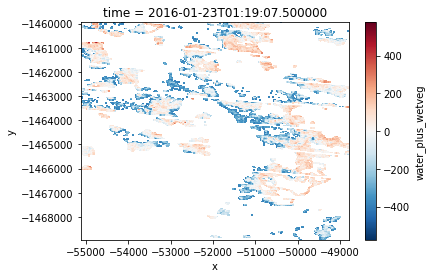

In [420]:
wetness_sensor2_nbart.water_plus_wetveg.isel(time=1).plot()

## count number of wetness scenes and number of times tcw above threshold for each pixel

In [415]:
counts_sensor_1_nbart = count_wets(wetness_sensor1_nbart)
counts_sensor_2_nbart = count_wets(wetness_sensor2_nbart)
counts_sensor_3_nbart = count_wets(wetness_sensor3_nbart)

did not count
counted
counted


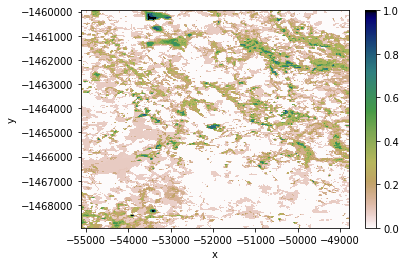

In [417]:
test = counts_sensor_3_nbart['threshold count']/counts_sensor_3_nbart['wet count']
test.plot(cmap ='gist_earth_r')
plt.show()

## divide the number of times wetness is seen per pixel by the number of wetness scenes per pixel to get a proportion of time that the pixel is wet

In [501]:
counts_list = [counts_sensor_1_nbart, counts_sensor_2_nbart,counts_sensor_3_nbart]
threshold_list =[]
wet_list=[]
for acount in counts_list:
    #test for data existence
    if acount is not None:
        wet_count = acount['wet count']
        threshold = acount['threshold count']
        threshold_list.append(threshold)
        wet_list.append(wet_count)
#times wetness is over threshold by pixel         
threshold_allsensors = sum(threshold_list) 
#number of wetness scenes by pixel
wet_count_allsensors = sum(wet_list)        
wet_proportion_allsensors = threshold_allsensors/wet_count_allsensors

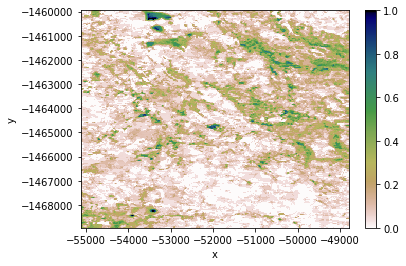

In [462]:
wet_proportion_allsensors.plot(cmap ='gist_earth_r')

In [508]:
print('successfully ran TCW for '+shape_name+' polygon number '+str(i))
eprint('successfully ran TCW for '+shape_name+' polygon number '+str(i))

successfully ran TCW for slice_0 polygon number 0


successfully ran TCW for slice_0 polygon number 0


## this is to steal the crs from whichever wetness array actually has one

In [479]:
if wetness_sensor1_nbart is not None:
    crs = wetness_sensor1_nbart.crs
else:
    if wetness_sensor2_nbart is not None:
        crs = wetness_sensor2_nbart.crs
    else: 
        crs = wetness_sensor3_nbart.crs
print(crs)     

EPSG:3577


In [506]:
write_your_netcdf(wet_proportion_allsensors,'tcw',filename=filename, crs=crs)
print('successfully wrote tcw netcdf for '+shape_name+' polygon number '+str(i))
eprint('successfully wrote tcw netcdf for for '+shape_name+' polygon number '+str(i))

RuntimeError: Storage Unit already exists: /g/data/r78/rjd547/groundwater_activities/Analysis/TCW_stats/slice_0NoPizza.nc
successfully wrote tcw netcdf for slice_0 polygon number 0


successfully tcw netcdf for for slice_0 polygon number 0


In [513]:
#overthresh is observations over our wetness threshold count per pixel
write_your_netcdf(threshold_allsensors,'overthresh',filename=netcdf_output_loc+shape_name+'_overthresh.nc',crs=crs)
print('successfully wrote overthresh netCDF for '+shape_name+' polygon number '+str(i))
eprint('successfully wrote overthresh netCDFfor '+shape_name+' polygon number '+str(i))

RuntimeError: Storage Unit already exists: /g/data/r78/rjd547/groundwater_activities/Analysis/TCW_stats/slice_0_overthresh.nc
successfully wrote overthresh netCDF for slice_0 polygon number 0


successfully wrote overthresh netCDFfor slice_0 polygon number 0


In [514]:
#clear_observations is count of wetness scenes at pixel
write_your_netcdf(wet_count_allsensors,'clearobs',filename=netcdf_output_loc+shape_name+'_clearobs.nc',crs=crs)
print('successfully wrote clearobs netCDF for '+shape_name+' polygon number '+str(i))
eprint('successfully wrote clearobs netCDFfor '+shape_name+' polygon number '+str(i))

successfully wrote clearobs netCDF for slice_0 polygon number 0


successfully wrote clearobs netCDFfor slice_0 polygon number 0
